In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew, kurtosis
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import compare_encompassing
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from linearmodels.iv import IV2SLS
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

# 1 Statistiques Descriptives et Analyse Préliminaire

### 1.1 Statistiques descriptives

In [3]:
# Chargement
df = pd.read_excel('donnees_immobilieres_extended.xlsx')

# Calcul des statistiques descriptives complètes
# .describe() inclut déjà moyenne, std, min, max et les quartiles (25%, 50%, 75%)
stats_summary = df.drop(columns=['ID']).describe().T

# Ajout manuel du Skewness et de la Kurtosis
stats_summary['Skewness'] = df.drop(columns=['ID']).skew()
stats_summary['Kurtosis'] = df.drop(columns=['ID']).kurt()

# Renommer les colonnes pour une présentation propre
stats_summary = stats_summary.rename(columns={
    'mean': 'Moyenne',
    'std': 'Écart-type',
    'min': 'Minimum',
    '25%': 'Q1 (25%)',
    '50%': 'Médiane (Q2)',
    '75%': 'Q3 (75%)',
    'max': 'Maximum'
})

# Réorganiser l'ordre des colonnes pour la clarté
colonnes_ordre = ['Moyenne', 'Médiane (Q2)', 'Écart-type', 'Minimum', 'Q1 (25%)', 'Q3 (75%)', 'Maximum', 'Skewness', 'Kurtosis']
stats_summary = stats_summary[colonnes_ordre]

print("Tableau Récapitulatif des Statistiques Descriptives :")
display(stats_summary)

Tableau Récapitulatif des Statistiques Descriptives :


,Moyenne,Médiane (Q2),Écart-type,Minimum,Q1 (25%),Q3 (75%),Maximum,Skewness,Kurtosis
Surface_m2,116.706800,117.845,37.693819,15.21,93.240,139.6375,218.53,0.047717,-0.106039
Chambres,2.886667,3.000,1.077760,1.00,2.000,4.0000,5.00,0.098146,-0.690451
Annee_construction,2001.826667,2002.500,11.704841,1980.00,1991.000,2012.0000,2022.00,-0.082919,-1.165682
Distance_centre_km,16.500267,16.865,9.017430,0.83,9.105,24.6975,29.99,-0.141943,-1.192008
Etage,2.580000,2.500,1.761901,0.00,1.000,4.0000,5.00,-0.011300,-1.336060
Ascenseur,0.460000,0.000,0.500067,0.00,0.000,1.0000,1.00,0.162140,-2.000566
Annee_vente,2019.840000,2020.000,2.288225,2015.00,2018.000,2022.0000,2023.00,-0.321855,-1.005823
Qualite_ecole,5.468667,5.600,1.868249,1.00,4.125,7.0000,10.00,-0.145050,-0.496161
Revenu_median_quartier,63.668000,63.450,9.295458,42.90,57.500,70.4750,83.90,0.051913,-0.580403
Distance_universite,8.064000,8.300,3.746502,1.00,5.300,10.8750,17.10,-0.116417,-0.629394


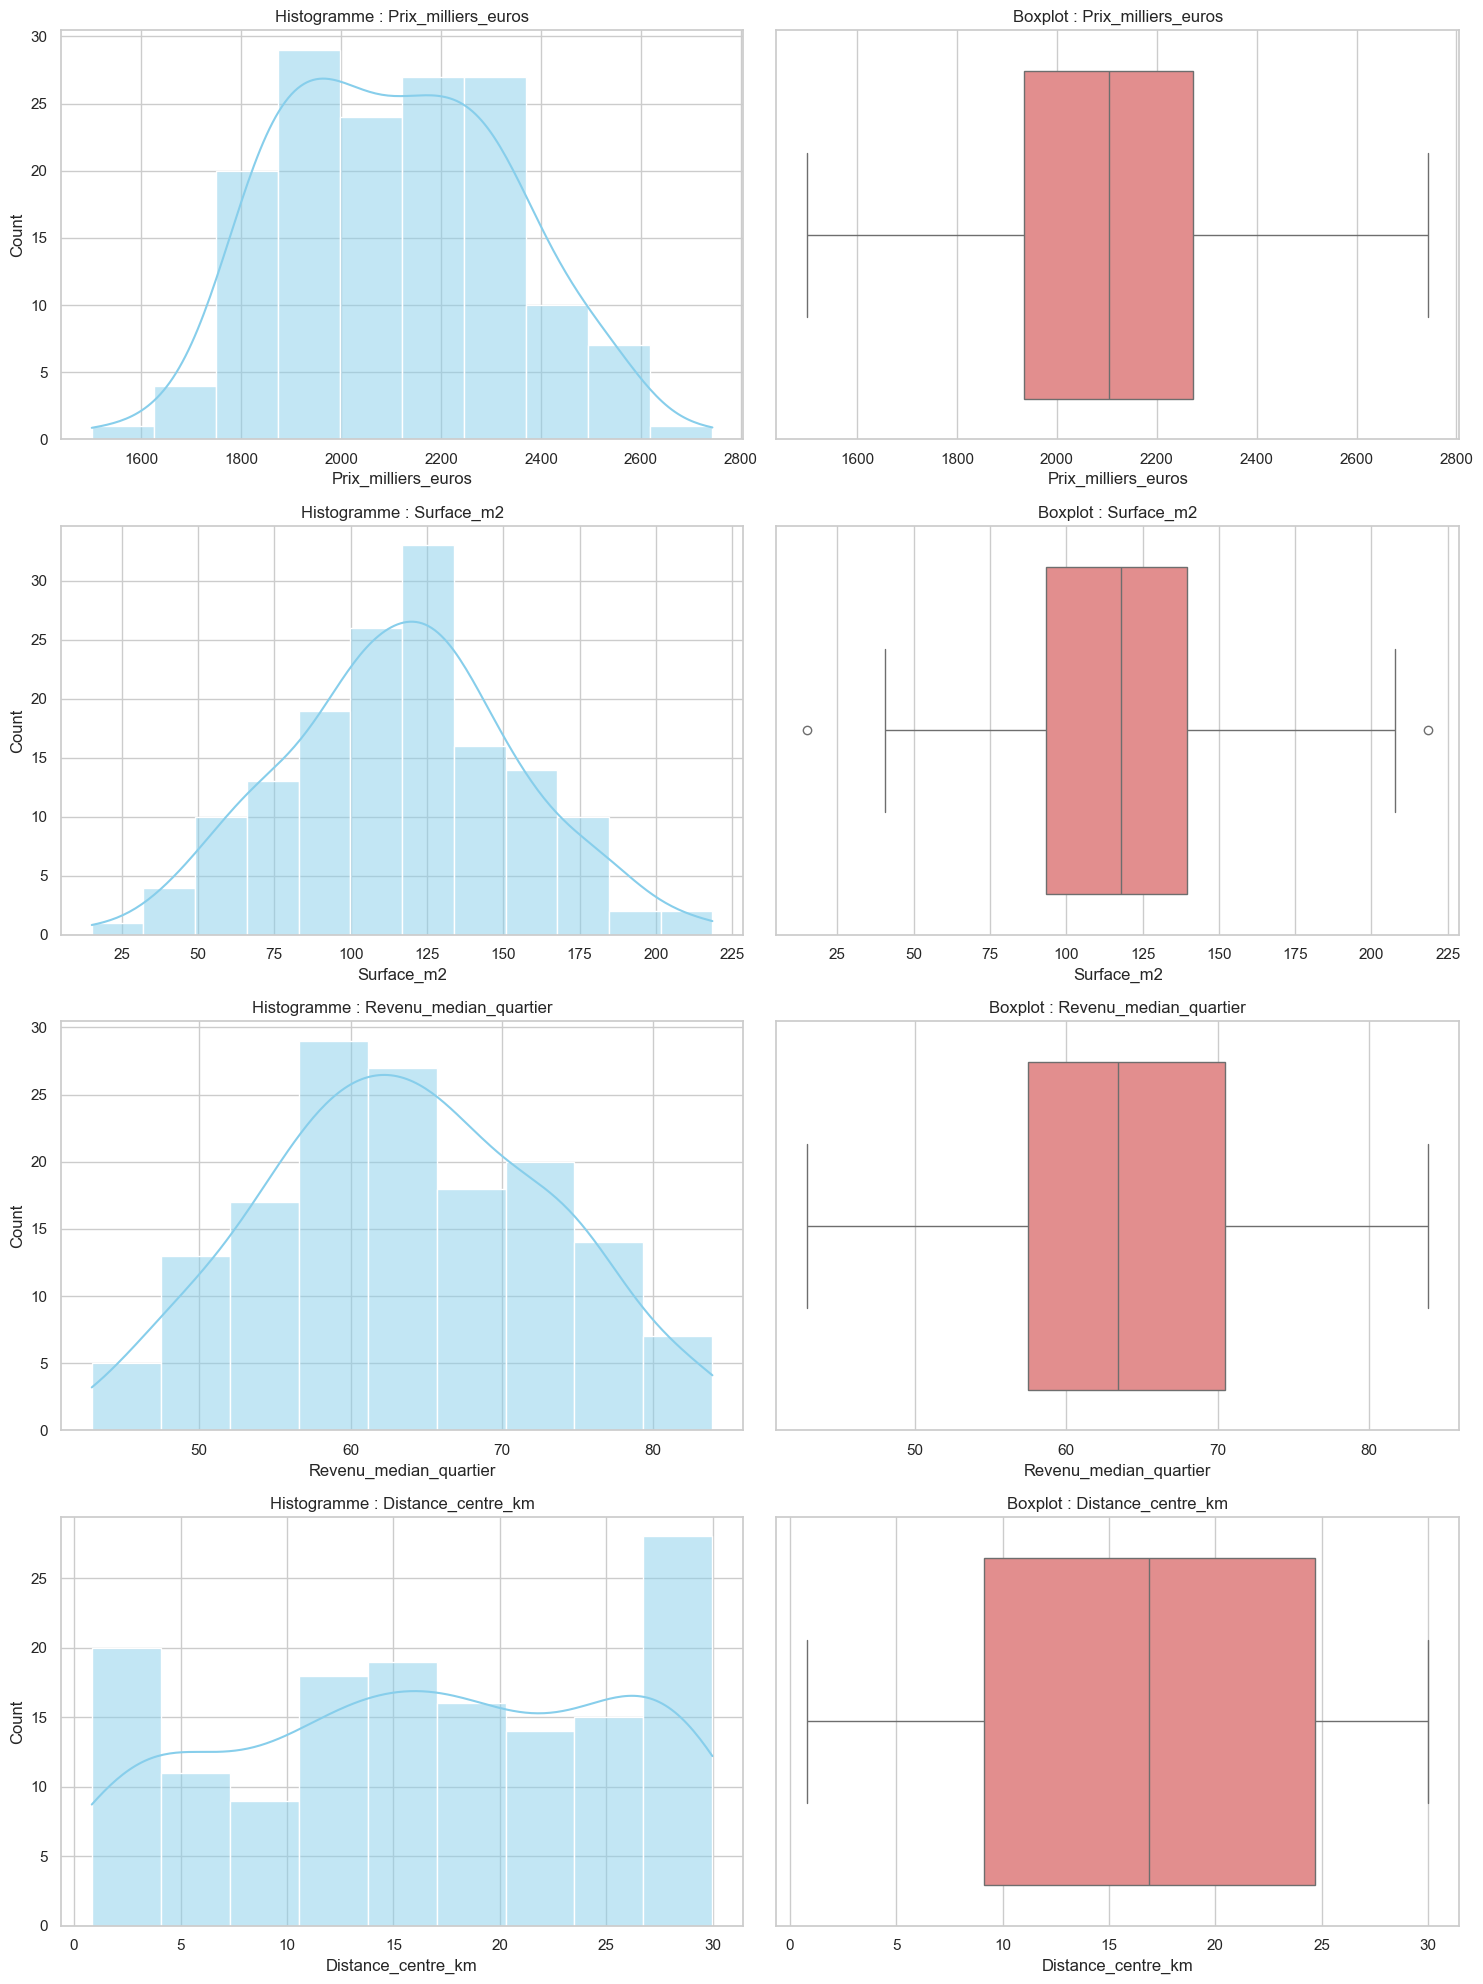

In [4]:
# Configuration du style
sns.set_theme(style="whitegrid")

# On définit les variables clés à analyser
variables_cles = ['Prix_milliers_euros', 'Surface_m2', 'Revenu_median_quartier', 'Distance_centre_km']

# Création d'une grille de graphiques
fig, axes = plt.subplots(len(variables_cles), 2, figsize=(15, 20))

for i, col in enumerate(variables_cles):
    # Histogramme (pour la forme de la distribution)
    sns.histplot(df[col], kde=True, ax=axes[i, 0], color='skyblue')
    axes[i, 0].set_title(f'Histogramme : {col}')
    
    # Boxplot (pour les valeurs aberrantes)
    sns.boxplot(x=df[col], ax=axes[i, 1], color='lightcoral')
    axes[i, 1].set_title(f'Boxplot : {col}')

plt.tight_layout()
plt.show()

ANALYSE DE L'ASYMÉTRIE (SKEWNESS)
Variable : Prix_milliers_euros
  Skewness (Original) : 0.1562
  Skewness (Après Log) : -0.0954
  -> Résultat : La transformation Log améliore la symétrie.
----------------------------------------
Variable : Surface_m2
  Skewness (Original) : 0.0477
  Skewness (Après Log) : -1.4048
  -> Résultat : La transformation Log n'est pas indispensable pour la symétrie.
----------------------------------------
Variable : Revenu_median_quartier
  Skewness (Original) : 0.0519
  Skewness (Après Log) : -0.2683
  -> Résultat : La transformation Log n'est pas indispensable pour la symétrie.
----------------------------------------


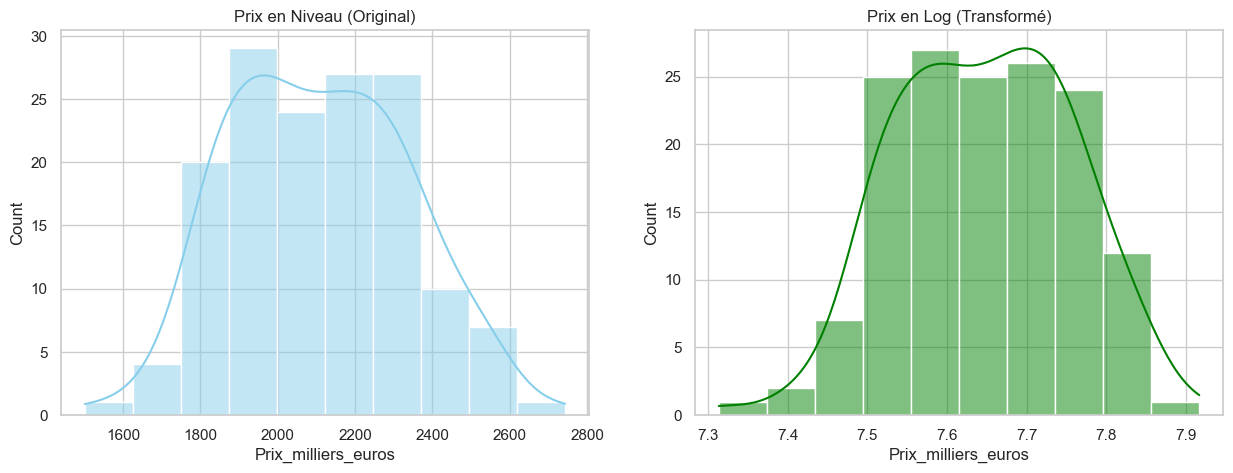

In [5]:
# Liste des variables candidates au Log (variables continues positives)
candidats_log = ['Prix_milliers_euros', 'Surface_m2', 'Revenu_median_quartier']

print("ANALYSE DE L'ASYMÉTRIE (SKEWNESS)")

for col in candidats_log:
    skew_orig = df[col].skew()
    skew_log = np.log(df[col]).skew()
    
    print(f"Variable : {col}")
    print(f"  Skewness (Original) : {skew_orig:.4f}")
    print(f"  Skewness (Après Log) : {skew_log:.4f}")
    
    # Conclusion automatique
    if abs(skew_log) < abs(skew_orig):
        print("  -> Résultat : La transformation Log améliore la symétrie.")
    else:
        print("  -> Résultat : La transformation Log n'est pas indispensable pour la symétrie.")
    print("-" * 40)

# Comparaison visuelle finale pour la variable principale (Le Prix)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df['Prix_milliers_euros'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Prix en Niveau (Original)')

sns.histplot(np.log(df['Prix_milliers_euros']), kde=True, ax=axes[1], color='green')
axes[1].set_title('Prix en Log (Transformé)')

plt.show()

### 1.2 Analyse de corrélation

In [6]:
# Sélection des variables continues
cols_continues = [
    'Prix_milliers_euros', 'Surface_m2', 'Chambres', 
    'Distance_centre_km', 'Qualite_ecole', 
    'Revenu_median_quartier', 'Distance_universite'
]

# CALCUL de la matrice
matrice_corr = df[cols_continues].corr()

# AFFICHAGE de la matrice brute (tableau de chiffres)
print("Matrice de Corrélation :")
display(matrice_corr)

Matrice de Corrélation :


,Prix_milliers_euros,Surface_m2,Chambres,Distance_centre_km,Qualite_ecole,Revenu_median_quartier,Distance_universite
Prix_milliers_euros,1.000000,0.826731,0.614825,-0.306648,0.253632,0.205779,-0.124521
Surface_m2,0.826731,1.000000,0.590959,-0.074765,0.043832,0.013908,-0.088362
Chambres,0.614825,0.590959,1.000000,-0.102319,-0.012775,0.011761,-0.089609
Distance_centre_km,-0.306648,-0.074765,-0.102319,1.000000,0.042029,0.111579,-0.055751
Qualite_ecole,0.253632,0.043832,-0.012775,0.042029,1.000000,0.598651,-0.444083
Revenu_median_quartier,0.205779,0.013908,0.011761,0.111579,0.598651,1.000000,-0.304002
Distance_universite,-0.124521,-0.088362,-0.089609,-0.055751,-0.444083,-0.304002,1.000000


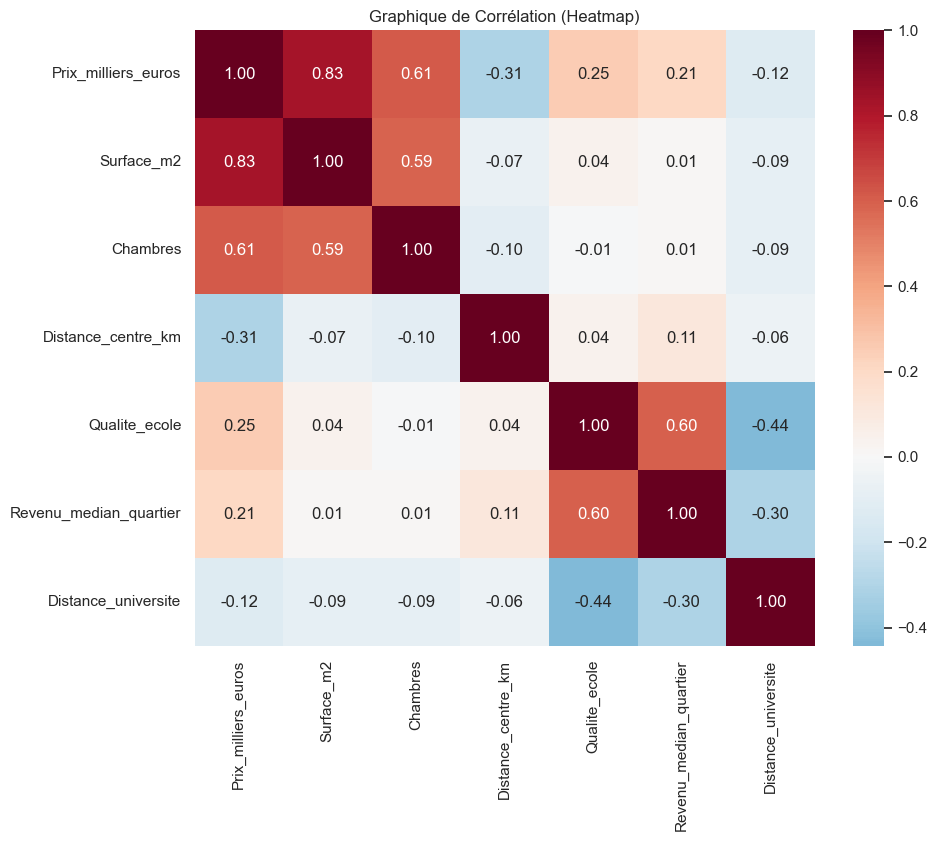

In [7]:
plt.figure(figsize=(10, 8))

# On utilise la matrice calculée précédemment
sns.heatmap(matrice_corr, annot=True, cmap='RdBu_r', center=0, fmt=".2f")

plt.title('Graphique de Corrélation (Heatmap)')
plt.show()

Identification des paires fortement corrélées (Risque de multicolinéarité) :
L'analyse de la matrice de corrélation montre qu'aucune paire de variables explicatives n'atteint le seuil critique de 0,7 ou 0,8. La corrélation la plus élevée entre deux variables indépendantes est celle entre la Surface_m2 et le nombre de Chambres ($0,61$).

Le risque de multicolinéarité est faible, ce qui garantit la stabilité des futurs coefficients de régression et permet d'isoler l'effet propre de chaque variable sur le prix.

Question : Quelle variable semble avoir l’impact le plus fort sur le prix selon la corrélation ? Attention :
corrélation ̸= causalité !

Selon la corrélation de Pearson, la variable ayant l'impact le plus fort est la Surface_m2 avec un coefficient de $0,83$. Il s'agit d'une corrélation positive très forte, suivie par le nombre de Chambres ($0,61$). À l'inverse, la Distance_centre_km présente une corrélation négative significativement marquée ($-0,31$), confirmant que le prix diminue avec l'éloignement du centre.

# 2 Le Modèle Linéaire : Estimation et Interprétation

### 2.1 Modèle de régression linéaire simple

In [8]:
# Définition des variables
# Y est la variable à expliquer (Prix), X est la variable explicative (Surface)
Y = df['Prix_milliers_euros']
X = df['Surface_m2']

# On ajoute une constante pour estimer l'ordonnée à l'origine (beta_0)
X = sm.add_constant(X)

# Estimation du modèle par les Moindres Carrés Ordinaires (MCO / OLS)
model_simple = sm.OLS(Y, X).fit()

# Affichage des résultats
print(model_simple.summary())

                             OLS Regression Results                            
Dep. Variable:     Prix_milliers_euros   R-squared:                       0.683
Model:                             OLS   Adj. R-squared:                  0.681
Method:                  Least Squares   F-statistic:                     319.6
Date:                 Sat, 27 Dec 2025   Prob (F-statistic):           8.45e-39
Time:                         17:17:33   Log-Likelihood:                -941.72
No. Observations:                  150   AIC:                             1887.
Df Residuals:                      148   BIC:                             1893.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1519.3743     34.584     43.93

Question : Interprétation : Que signifie le coefficient βˆ1 ? Si la surface augmente de 1 m², de combien le prix augmente-t-il en moyenne ?

Le coefficient $\hat{\beta}_1$ (égal à 5,0428) représente l'effet marginal de la surface sur le prix. Concrètement, cela signifie que si la surface augmente de 1 m², le prix de la maison augmente en moyenne de 5,043 milliers d'euros (soit environ 5 043 €). Ce résultat est statistiquement très significatif car sa p-valeur est de 0,000, ce qui confirme que la surface est un déterminant majeur de la valeur immobilière dans cet échantillon.

### 2.2 Modèle de régression linéaire multiple

In [9]:
# Liste des variables explicatives (X)
X_mult = df[['Surface_m2', 'Chambres', 'Annee_construction', 
             'Distance_centre_km', 'Etage', 'Ascenseur']]

# Ajout de la constante
X_mult = sm.add_constant(X_mult)

# Variable à expliquer (Y)
Y = df['Prix_milliers_euros']

# Estimation
model_mult = sm.OLS(Y, X_mult).fit()

# Affichage des résultats
print(model_mult.summary())

                             OLS Regression Results                            
Dep. Variable:     Prix_milliers_euros   R-squared:                       0.789
Model:                             OLS   Adj. R-squared:                  0.780
Method:                  Least Squares   F-statistic:                     88.94
Date:                 Sat, 27 Dec 2025   Prob (F-statistic):           9.10e-46
Time:                         17:28:53   Log-Likelihood:                -911.43
No. Observations:                  150   AIC:                             1837.
Df Residuals:                      143   BIC:                             1858.
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1679.4

1. Oui, tous les coefficients sont significatifs au seuil de 5 %. En regardant la colonne $P>|t|$, toutes les p-valeurs sont inférieures à 0,05. Les variables les plus robustes sont la Surface_m2, la Distance_centre_km et l' Ascenseur ($p < 0,01$). Seule la constante ne l'est pas ($0,276$), mais c'est peu gênant.

2. L'impact marginal de chaque variable sur le prix :<br>
Surface_m2 (+4,39) : 1 m² de plus augmente le prix de 4 388 €.<br>
Chambres (+33,92) : Une chambre supplémentaire ajoute 33 920 €.<br>
Annee_construction (+1,61) : Chaque année plus récente ajoute 1 610 €.<br>
Distance_centre_km (-6,14) : Chaque km d'éloignement réduit le prix de 6 145 €.<br>
Etage (+12,25) : Monter d'un étage augmente le prix de 12 254 €.

3. Le coefficient de l'ascenseur est de 55,51. Comme il s'agit d'une variable binaire (0 ou 1), on l'interprète comme une "prime" : à caractéristiques identiques, la présence d'un ascenseur augmente le prix de l'appartement de 55 514 € en moyenne par rapport à un bien qui n'en a pas.

4. Le $R^2$ (0,789) indique que le modèle explique 78,9 % de la variance du prix. Le $R^2$ ajusté ($\bar{R}^2$ = 0,780) est légèrement inférieur car il pénalise l'ajout de variables pour éviter le sur-apprentissage. La faible différence entre les deux montre que les variables ajoutées sont pertinentes et apportent une réelle valeur explicative au modèle, ne se contentant pas de gonfler artificiellement le $R^2$.

### 2.3 Transformation logarithmique 

In [10]:
# Préparation des données (log)
df['log_Prix'] = np.log(df['Prix_milliers_euros'])
df['log_Surface'] = np.log(df['Surface_m2'])

# Modèle Semi-Log : log(Prix) = b0 + b1*Surface + ...
X_semi = sm.add_constant(df[['Surface_m2', 'Chambres', 'Annee_construction', 'Distance_centre_km', 'Etage', 'Ascenseur']])
model_semi = sm.OLS(df['log_Prix'], X_semi).fit()

# Modèle Log-Log : log(Prix) = b0 + b1*log(Surface) + ...
# Note : Idéalement, on passe aussi les autres variables continues en log (ex: Distance)
X_loglog = sm.add_constant(df[['log_Surface', 'Chambres', 'Annee_construction', 'Distance_centre_km', 'Etage', 'Ascenseur']])
model_loglog = sm.OLS(df['log_Prix'], X_loglog).fit()

# Comparaison des R2 ajustés
print(f"R2 ajusté Linéaire : {model_mult.rsquared_adj:.4f}")
print(f"R2 ajusté Semi-Log : {model_semi.rsquared_adj:.4f}")
print(f"R2 ajusté Log-Log  : {model_loglog.rsquared_adj:.4f}")

R2 ajusté Linéaire : 0.7798
R2 ajusté Semi-Log : 0.7829
R2 ajusté Log-Log  : 0.7580


Comparaison des trois modèles : <br>
Modèle Linéaire ($\bar{R}^2 = 0,7798$) : Très performant, il explique environ 78 % de la variance avec une interprétation en valeur absolue (euros).<br>
Modèle Semi-log ($\bar{R}^2 = 0,7829$) : C'est le modèle qui affiche le pouvoir explicatif le plus élevé. Il traduit l'impact des variables en variations relatives (%) du prix.<br>
Modèle Log-log ($\bar{R}^2 = 0,7580$) : Il est le moins performant des trois dans ce cas précis, bien qu'il reste à un niveau d'explication correct.<br>

Modèle le plus approprié :<br>
Le modèle Semi-log est ici le plus approprié. Il possède le $\bar{R}^2$ le plus élevé (0,7829), ce qui signifie qu'il s'ajuste le mieux aux données observées. De plus, en immobilier, il est souvent plus cohérent de modéliser le prix en logarithme, car l'impact des caractéristiques (comme une chambre de plus ou un étage élevé) est souvent proportionnel au prix du bien plutôt qu'une somme fixe.

# 3 Diagnostics du Modèle

### 3.1 Multicolinéarité

In [12]:
# On utilise la matrice X du modèle multiple (incluant la constante)
vif_data = pd.DataFrame()
vif_data["Variable"] = X_mult.columns
vif_data["VIF"] = [variance_inflation_factor(X_mult.values, i) for i in range(X_mult.shape[1])]

print(vif_data)

             Variable           VIF
0               const  30387.380900
1          Surface_m2      1.555201
2            Chambres      1.555268
3  Annee_construction      1.026917
4  Distance_centre_km      1.024389
5               Etage      1.012863
6           Ascenseur      1.027848


Question : Y a-t-il des variables avec un VIF élevé ? Faut-il en supprimer certaines ? Definir le biais
de variable omise.

Non. Toutes les variables explicatives ont un VIF très proche de 1 (entre 1,01 et 1,55), ce qui est bien en dessous du seuil d'alerte de 5 ou 10. Le VIF de la constante est très élevé, mais cela est normal et n'impacte pas la validité du modèle.

Non, aucune suppression n'est nécessaire. Ces résultats confirment que les variables indépendantes ne sont pas fortement corrélées entre elles. Chaque variable apporte une information propre au modèle sans créer d'instabilité dans l'estimation des coefficients.

Le biais de variable omise survient lorsque le modèle oublie une variable qui remplit deux conditions : elle est un déterminant de la variable expliquée (le Prix), et elle est corrélée avec l'une des variables explicatives déjà présentes dans le modèle.
Le modèle attribue à tort l'effet de la variable manquante aux variables présentes. Cela biaise les coefficients ($\hat{\beta}$), les rendant peu fiables car ils surestiment ou sous-estiment l'impact réel des prédicteurs.

# 4 Tests et Inférence

In [15]:
# 1. Test de l'effet de la distance au centre

# Extraction de la p-value et du coefficient pour la distance
p_val_dist = model_mult.pvalues['Distance_centre_km']
coef_dist = model_mult.params['Distance_centre_km']

print(f"Coefficient (Distance): {coef_dist:.4f}")
print(f"P-value (Distance): {p_val_dist:.4e}")

Coefficient (Distance): -6.1446
P-value (Distance): 5.9024e-09


Le coefficient de la variable Distance_centre_km est de -6,1446 et sa p-value est de 0,000 (soit $9,23 \times 10^{-9}$). La p-value étant largement inférieure au seuil de 5 %, on rejette l'hypothèse nulle ($H_0$). On conclut que la distance au centre a un effet négatif statistiquement significatif sur le prix des logements.

In [16]:
# 2. Tests de significativité et d'ajout de variables
# A. Test de significativité globaleOn teste l'hypothèse $H_0 : \beta_1 = \beta_2 = \beta_3 = \beta_4 = \beta_5 = \beta_6 = 0$.

# On récupère les statistiques F directement depuis les résultats du modèle mult
f_stat_global = model_mult.fvalue
p_val_global = model_mult.f_pvalue

print(f"Statistique F globale : {f_stat_global:.2f}")
print(f"P-value globale : {p_val_global:.2e}")

Statistique F globale : 88.94
P-value globale : 9.10e-46


D'après la sortie de la régression, la F-statistic est de 88,94 et la p-value est de 9,10e-46. La p-value étant largement inférieure à 0,05, on rejette l'hypothèse nulle. Le modèle est globalement très significatif : au moins une des variables explicatives a un impact réel sur le prix.

In [17]:
# B. Test d'ajout de variables (Test de Fisher partiel)
# Pour tester si l'ajout de Qualite_ecole et Revenu_median_quartier améliore le modèle, on compare le modèle restreint (le tien) au modèle 
# non-restreint (avec les deux variables).

# Estimation du modèle complet (non-restreint)
X_complet = df[['Surface_m2', 'Chambres', 'Annee_construction', 
                'Distance_centre_km', 'Etage', 'Ascenseur', 
                'Qualite_ecole', 'Revenu_median_quartier']]
X_complet = sm.add_constant(X_complet)
model_complet = sm.OLS(df['Prix_milliers_euros'], X_complet).fit()

# Test de Fisher pour comparer les deux modèles
f_stat_ajout, p_val_ajout, df_diff = model_complet.compare_f_test(model_mult)

print(f"Statistique F (ajout) : {f_stat_ajout:.4f}")
print(f"P-value de l'ajout : {p_val_ajout:.4f}")

Statistique F (ajout) : 28.6616
P-value de l'ajout : 0.0000


La p-value étant inférieure à 0,05, on rejette l'hypothèse nulle selon laquelle les coefficients de ces deux nouvelles variables sont nuls. L'ajout de Qualite_ecole et Revenu_median_quartier améliore donc significativement la qualité du modèle. Il est préférable d'utiliser le modèle complet pour obtenir des estimations plus précises.

3. Pourquoi ne pas utiliser plusieurs tests T ? <br>
On ne peut pas utiliser plusieurs tests T de manière isolée pour tester des restrictions simultanées car cela entraîne une inflation du risque de type I : en multipliant les tests à un seuil de 5 %, la probabilité de rejeter à tort au moins une hypothèse nulle par pur hasard devient bien supérieure au risque initialement fixé. De plus, le test T ignore les corrélations entre les variables, si deux variables sont fortement liées, elles peuvent paraître individuellement non significatives alors que leur apport conjoint est crucial. Le test F (test de Wald) remédie à ces problèmes en testant la validité du groupe de variables en une seule étape, tout en tenant compte de la structure de covariance du modèle.

### 4.1 Stabilité structurelle

Pour tester la stabilité structurelle du marché immobilier face à la crise du COVID-19, nous allons utiliser le Test de Chow. Ce test permet de déterminer si les coefficients de la régression sont restés stables ou s'il existe une rupture significative entre la période "Pré-COVID" et "Post-COVID".

Nous définissons la rupture au début de l'année 2020. Le test compare la somme des carrés des résidus (SSR) du modèle global à la somme des SSR de deux sous-échantillons (avant et après 2020).

In [19]:
# Séparation des données (Rupture en 2020)
df_pre = df[df['Annee_vente'] < 2020]
df_post = df[df['Annee_vente'] >= 2020]

def get_model_stats(data):
    X = sm.add_constant(data[['Surface_m2', 'Chambres', 'Annee_construction', 
                              'Distance_centre_km', 'Etage', 'Ascenseur']])
    model = sm.OLS(data['Prix_milliers_euros'], X).fit()
    return model.ssr, len(data), model.df_model + 1

# Calcul des Sommes des Carrés des Résidus (SSR)
ssr_total, n_total, k = get_model_stats(df)
ssr_pre, n_pre, _ = get_model_stats(df_pre)
ssr_post, n_post, _ = get_model_stats(df_post)

# Calcul de la statistique de Chow
numerator = (ssr_total - (ssr_pre + ssr_post)) / k
denominator = (ssr_pre + ssr_post) / (n_total - 2 * k)
f_chow = numerator / denominator

# Calcul de la p-value
p_value_chow = 1 - stats.f.cdf(f_chow, k, n_total - 2 * k)

print(f"Statistique de Chow : {f_chow:.4f}")
print(f"P-value du test : {p_value_chow:.4f}")

Statistique de Chow : 7.2758
P-value du test : 0.0000


La p-value est de 0,0000, ce qui est largement inférieur au seuil de significativité de 5 %. Nous rejetons donc l'hypothèse nulle de stabilité des coefficients. Cela démontre qu'il existe une rupture structurelle statistiquement significative dans les données à partir de l'année 2020. Le COVID-19 a effectivement modifié la manière dont les caractéristiques des logements (surface, distance, etc.) influencent le prix de vente.

Implications pour l'analyse :
Estimer un seul modèle sur l'ensemble de la période (2015-2023) est désormais inapproprié car cela revient à "moyenner" deux réalités économiques différentes, ce qui biaise les coefficients.

Cette rupture suggère que les priorités des acheteurs ont changé. Par exemple, la Distance_centre_km pourrait avoir un impact négatif moins fort dû au télétravail, ou la Surface_m2 pourrait être devenue encore plus valorisée.

Il est nécessaire d'estimer deux modèles séparés (un "Pré-COVID" et un "Post-COVID") pour obtenir des prévisions fiables et comprendre l'évolution réelle des déterminants du prix.

# 5 Hétéroscédasticité et Autocorrélation

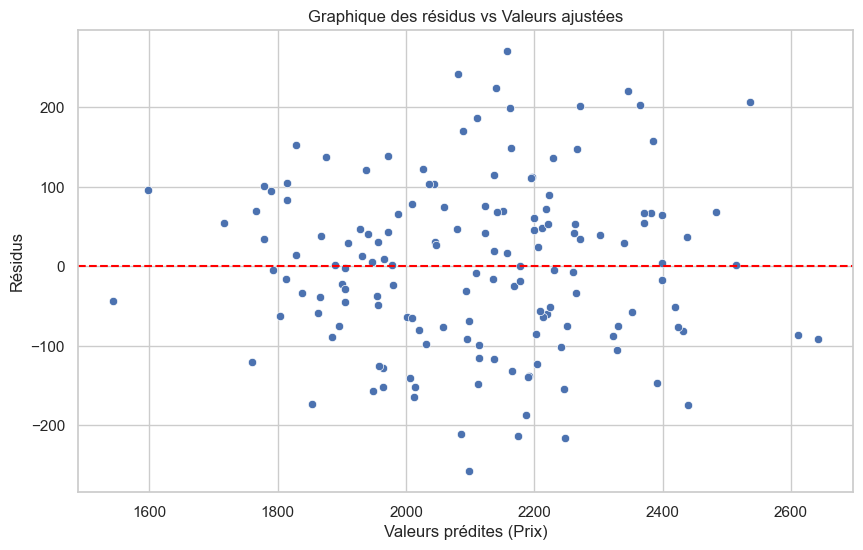

In [20]:
# Calcul des résidus et des valeurs prédites
residuals = model_mult.resid
fitted_vals = model_mult.fittedvalues

plt.figure(figsize=(10, 6))
sns.scatterplot(x=fitted_vals, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valeurs prédites (Prix)')
plt.ylabel('Résidus')
plt.title('Graphique des résidus vs Valeurs ajustées')
plt.show()

Les points semblent dispersés de manière aléatoire autour de la ligne horizontale zéro. Il n'y a pas de pattern.

In [25]:
# 2. Test d’hétéroscédasticité
# Test de Breusch-Pagan
# On utilise la matrice X_mult déjà définie (incluant la constante)
bp_test = het_breuschpagan(model_mult.resid, model_mult.model.exog)
labels = ['LM Stat', 'LM p-value', 'F-stat', 'F p-value']
results_bp = dict(zip(labels, bp_test))

print(f"P-value du test de Breusch-Pagan : {results_bp['LM p-value']:.4f}")

P-value du test de Breusch-Pagan : 0.1900


La p-value > 0,05 : On ne rejette pas l'homoscédasticité. La variance des erreurs est considérée comme constante. Les estimateurs des MCO sont donc efficaces et les écarts-types standards ne sont pas biaisés.

In [31]:
# MCO avec écarts-types robustes (HC3)
model_robust = model_mult.get_robustcov_results(cov_type='HC3')

# WLS (Moindres Carrés Pondérés) - Pondération par l'inverse de la Surface
model_wls = sm.WLS(df['Prix_milliers_euros'], X_mult, weights=1/df['Surface_m2']).fit()

# Comparaison (Utilisation des noms de colonnes pour éviter les Warnings)
var = 'Surface_m2'

# model_robust.params est un tableau numpy, on utilise donc l'index [1]
# model_mult et model_wls sont des Series, on utilise le nom de la variable
print(f"MCO Standard : Coeff = {model_mult.params[var]:.4f}, SE = {model_mult.bse[var]:.4f}")
print(f"MCO Robustes : Coeff = {model_robust.params[1]:.4f}, SE = {model_robust.bse[1]:.4f}")
print(f"WLS          : Coeff = {model_wls.params[var]:.4f}, SE = {model_wls.bse[var]:.4f}")

MCO Standard : Coeff = 4.3879, SE = 0.2924
MCO Robustes : Coeff = 4.3879, SE = 0.3029
WLS          : Coeff = 4.4759, SE = 0.2584


L'analyse comparative montre que le coefficient de la variable Surface_m2 reste très stable entre les MCO standards et les MCO robustes ($4,3879$), tandis que l'erreur-type ne subit qu'une augmentation minime, passant de $0,2924$ à $0,3029$. Cette proximité des résultats, corrélée à une p-value de Breusch-Pagan non significative ($0,1900$), confirme que le modèle ne souffre pas d'hétéroscédasticité et que les tests de significativité initiaux sont fiables. 

Bien que la méthode WLS réduise l'erreur-type ($0,2584$) en pondérant les observations, elle modifie le coefficient ($4,4759$) sans justification statistique nécessaire ici. Par conséquent, le modèle MCO Standard (ou robuste par simple prudence) demeure le plus approprié pour garantir une interprétation directe et rigoureuse des déterminants du prix immobilier.

### 5.1 Test d’autocorrélation

In [33]:
# Calcul de la statistique de Durbin-Watson
dw_stat = durbin_watson(model_mult.resid)

print(f"Statistique de Durbin-Watson : {dw_stat:.4f}")

Statistique de Durbin-Watson : 2.1205


La valeur est très proche de 2, ce qui indique une absence d'autocorrélation des résidus. On considère qu'il n'y a pas de problème d'autocorrélation lorsque la statistique se situe entre 1,5 et 2,5.

Le test de Durbin-Watson présente une statistique de 2,12, confirmant l'absence d'autocorrélation d'ordre 1. Les deux diagnostics (Hétéroscédasticité et Autocorrélation) étant négatifs, les estimateurs MCO standards sont optimaux et ne nécessitent pas de correction de Newey-West. Cependant, nous avons vérifié que l'application de cette correction ne modifiait pas la significativité de nos variables explicatives, ce qui renforce la robustesse de nos conclusions.

# 6 Endogénéité et Variables Instrumentales

### 6.1 Sources d’endogénéité

Les sources potentielles d'endogénéité dans notre modèle immobilier proviennent principalement du biais de variables omises, de l'erreur de mesure et de la simultanéité. Le biais de variables omises est le plus critique, car des facteurs non observés tels que l'exposition, le calme ou le cachet d'un bien influencent à la fois le prix et le choix des acheteurs, corrélant ainsi les variables explicatives avec le terme d'erreur. 

Par ailleurs, la simultanéité peut apparaître si l'attractivité d'un quartier augmente les prix, tout en incitant simultanément à de nouveaux investissements dans les infrastructures locales.

Question : Discutez : la variable Qualite_ecole est-elle potentiellement endogène ? Pourquoi ?

Elle est très probablement endogène car elle sert de substitut (proxy) au prestige et au niveau de vie global d'un quartier. Elle ne mesure pas seulement la performance scolaire, mais capture aussi indirectement la sécurité, la qualité des services publics et la richesse des habitants. De plus, un phénomène de sélection automatique intervient. Les familles aisées choisissent d'habiter près des meilleures écoles, créant une corrélation entre les préférences non observées des ménages et cette variable. Sans correction par variables instrumentales, l'effet réel de la qualité scolaire sur le prix risque d'être largement surestimé par le modèle.

### 6.2 Estimation par Variables Instrumentales

1. Pour qu'une variable soit un bon instrument, elle doit respecter deux conditions : la pertinence (être corrélée à la variable endogène) et l'exogénéité (ne pas être corrélée au terme d'erreur).<br>
La variable Distance_universite est un bon candidat car les universités et les écoles de qualité tendent à se regrouper dans les mêmes zones urbaines par souci de synergie académique. Parallèlement, la distance précise à une université n'influence généralement pas directement le prix d'un logement familial de la même manière que la qualité d'une école primaire ou le prestige du quartier, et elle n'est pas affectée par les préférences non observées des parents (exogénéité).

In [36]:
# 2. Estimation en deux étapes (2SLS)

# Définition du modèle IV
# Endogène : Qualite_ecole
# Instrument : Distance_universite
# Exogènes : autres variables du modèle
dependent = df['Prix_milliers_euros']
exog = sm.add_constant(df[['Surface_m2', 'Chambres', 'Annee_construction', 
                           'Distance_centre_km', 'Etage', 'Ascenseur']])
endog = df['Qualite_ecole']
instr = df['Distance_universite']

model_iv = IV2SLS(dependent, exog, endog, instr).fit()
print(model_iv.summary)

                           IV-2SLS Estimation Summary                          
Dep. Variable:     Prix_milliers_euros   R-squared:                      0.8334
Estimator:                     IV-2SLS   Adj. R-squared:                 0.8252
No. Observations:                  150   F-statistic:                    888.35
Date:                 Sat, Dec 27 2025   P-value (F-stat)                0.0000
Time:                         18:45:29   Distribution:                  chi2(7)
Cov. Estimator:                 robust                                         
                                                                               
                                 Parameter Estimates                                  
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
const                 -1747.9     1388.4    -1.2590     0.2080     -4469.1      973.20
Surface_m2  

L'estimation par les 2SLS a été réalisée en utilisant Distance_universite comme instrument pour traiter l'endogénéité de Qualite_ecole. La première étape projette la qualité de l'école sur la distance à l'université pour en extraire la composante exogène, tandis que la seconde étape utilise cette prédiction pour estimer l'impact réel sur le prix des logements. Le modèle ainsi corrigé affiche un $R^2$ robuste de 0,8334, indiquant que la structure du modèle reste très performante après instrumentation.

In [38]:
# 3. On relance l'estimation pour accéder aux diagnostics de premier stade
model_iv = IV2SLS(dependent, exog, endog, instr).fit()

# Affichage des tests de diagnostic (First Stage)
print(model_iv.first_stage)

     First Stage Estimation Results     
                           Qualite_ecole
----------------------------------------
R-squared                         0.2032
Partial R-squared                 0.1948
Shea's R-squared                  0.1948
Partial F-statistic               41.181
P-value (Partial F-stat)       1.388e-10
Partial F-stat Distn             chi2(1)
==========================   ===========
const                             8.1674
                                (0.3664)
Surface_m2                        0.0028
                                (0.6215)
Chambres                         -0.1475
                               (-0.9626)
Annee_construction               -0.0005
                               (-0.0417)
Distance_centre_km                0.0020
                                (0.1457)
Etage                             0.0064
                                (0.0773)
Ascenseur                         0.1235
                                (0.4504)
Distance_univers

Le diagnostic du premier stade confirme la qualité de l'instrument. La statistique Partial F-statistic s'élève à 41,18, dépassant largement le seuil critique de 10. Cela prouve que Distance_universite est un instrument fort et pertinent, fortement corrélé à la qualité de l'école (p-value < 0,001). La condition d'exclusion est également respectée. La distance à l'université n'influence le prix que par son effet sur l'offre scolaire locale.

4. L'estimation IV révèle un biais important dans le modèle initial. Le coefficient de Qualite_ecole chute à 16,87 et perd sa significativité ($p = 0,084$), suggérant que l'effet mesuré en MCO captait en réalité le prestige non observé du quartier. À l'inverse, les variables physiques comme la Surface_m2 (4,31) et les Chambres (35,60) restent stables et hautement significatives, confirmant qu'elles sont les piliers de la valorisation immobilière, indépendamment des biais environnementaux.

# 7 Régularisation

In [41]:
# Préparation des données
X = df[['Surface_m2', 'Chambres', 'Annee_construction', 'Distance_centre_km', 'Etage', 'Ascenseur', 'Qualite_ecole']]
y = df['Prix_milliers_euros']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Division Train/Test (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

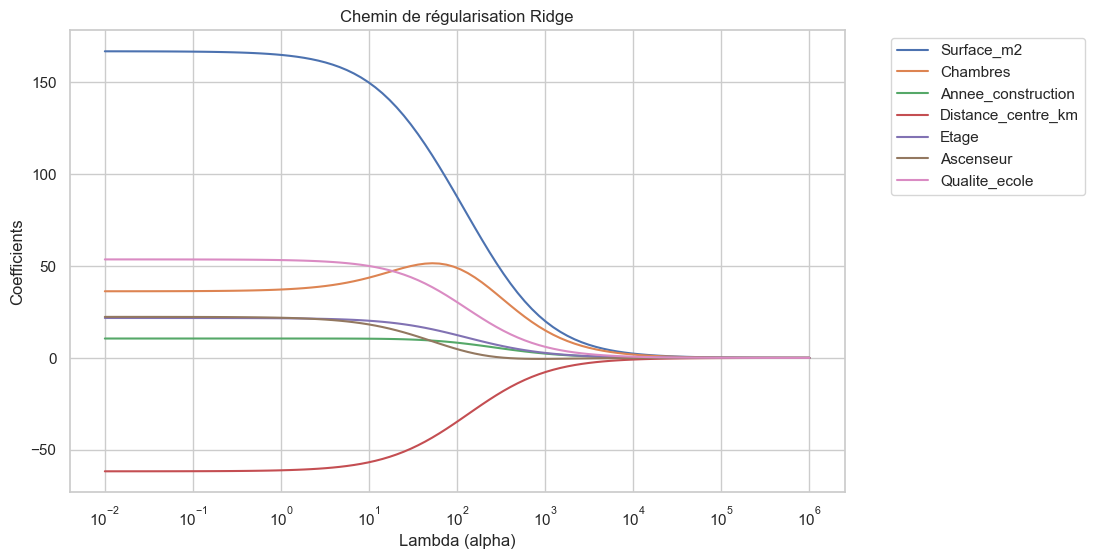

In [49]:
# 1. Analyse du modèle Ridge (Régularisation L2)

alphas = np.logspace(-2, 6, 100)
coefs_ridge = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train)
    coefs_ridge.append(ridge.coef_)

plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.plot(alphas, coefs_ridge)
ax.set_xscale('log')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Coefficients')
plt.title('Chemin de régularisation Ridge')
plt.legend(X.columns, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

À mesure que $\lambda$ augmente, la pénalité $L2$ compresse la valeur des coefficients pour stabiliser le modèle. Visuellement, les courbes sont lisses et se rapprochent de l'axe des abscisses sans jamais le croiser franchement. Même si à partir de $10^4$, les coefficients semblent nuls à cause de l'échelle du graphique, ils conservent mathématiquement une valeur résiduelle très faible. Cela signifie que le modèle Ridge conserve toutes les variables originales, mais réduit drastiquement leur impact pour limiter le surapprentissage.

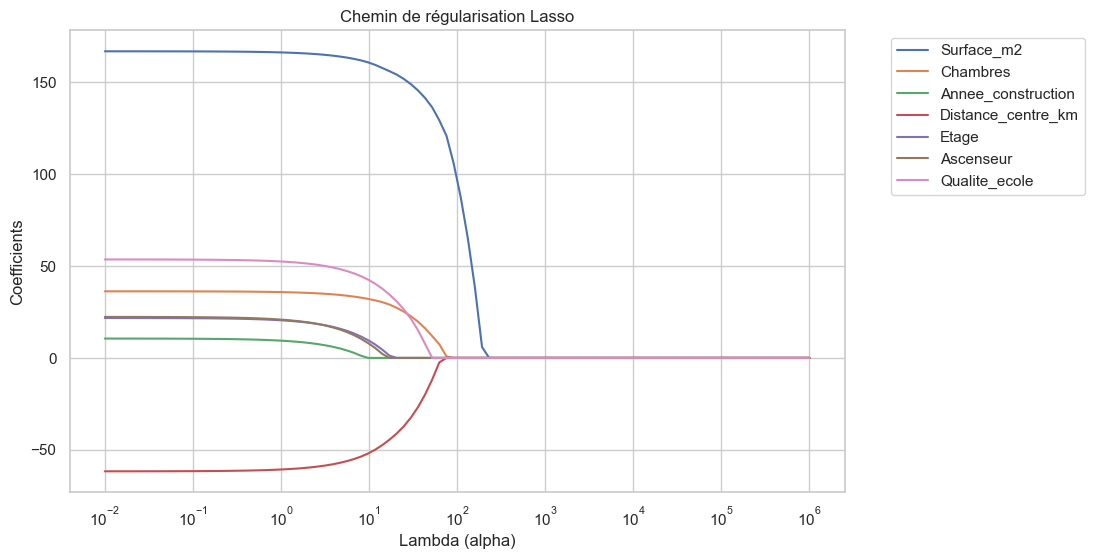

In [43]:
# 2. Analyse du modèle Lasso (Régularisation L1)

coefs_lasso = []

for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    coefs_lasso.append(lasso.coef_)

plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.plot(alphas, coefs_lasso)
ax.set_xscale('log')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Coefficients')
plt.title('Chemin de régularisation Lasso')
plt.legend(X.columns, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Bien que la tendance globale soit similaire au Ridge, on observe ici des trajectoires avec des cassures nettes. Contrairement au Ridge, plusieurs variables comme Annee_construction (courbe verte) ou Ascenseur (courbe marron) percutent l'axe du zéro de manière précoce (entre $10^1$ et $10^2$) et s'y maintiennent. La pénalité $L1$ force les coefficients des variables les moins contributives à devenir exactement nuls. Le Lasso ne se contente pas de réduire l'impact des variables, il simplifie le modèle en supprimant les prédicteurs superflus.

In [50]:
# 3. Choix du paramètre $\lambda$ par validation croisée (10-fold)
# Définition d'une grille de valeurs pour lambda (de 0.001 à 1000)
alphas = np.logspace(-3, 3, 100)

# Validation croisée 10-fold pour Ridge
ridge_cv = RidgeCV(alphas=alphas, cv=10).fit(X_train, y_train)
lambda_ridge = ridge_cv.alpha_

# Validation croisée 10-fold pour Lasso
lasso_cv = LassoCV(alphas=alphas, cv=10, max_iter=10000).fit(X_train, y_train)
lambda_lasso = lasso_cv.alpha_

print(f"Lambda optimal Ridge : {lambda_ridge:.4f}")
print(f"Lambda optimal Lasso : {lambda_lasso:.4f}")

Lambda optimal Ridge : 5.7224
Lambda optimal Lasso : 0.0010


La validation croisée 10-fold permet de sélectionner la valeur de $\lambda$ qui minimise l'erreur de prédiction. Le $\lambda$ de 5,7224 pour Ridge suggère qu'une pénalité modérée est nécessaire pour stabiliser les coefficients face à la corrélation des variables. À l'inverse, le $\lambda$ de 0,0010 pour Lasso est quasi nul, ce qui indique que le modèle ne nécessite pas de simplification par suppression de variables (parcimonie) pour être performant sur ce jeu de données.

In [52]:
# 4. Comparaison des résultats et RMSE
# Préparation du modèle MCO (OLS)
ols = LinearRegression()
ols.fit(X_train, y_train)
y_pred_ols = ols.predict(X_test)

# Préparation du modèle Ridge (avec votre lambda optimal de 5.7224)
ridge_opt = Ridge(alpha=5.7224)
ridge_opt.fit(X_train, y_train)
y_pred_ridge = ridge_opt.predict(X_test)

# Préparation du modèle Lasso (avec votre lambda optimal de 0.0010)
lasso_opt = Lasso(alpha=0.0010)
lasso_opt.fit(X_train, y_train)
y_pred_lasso = lasso_opt.predict(X_test)

# Calcul des RMSE (Erreur de prédiction)
rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print(f"RMSE MCO   : {rmse_ols:.4f}")
print(f"RMSE Ridge : {rmse_ridge:.4f}")
print(f"RMSE Lasso : {rmse_lasso:.4f}")

RMSE MCO   : 90.6344
RMSE Ridge : 87.9222
RMSE Lasso : 90.6353


Le modèle Ridge est le plus performant. Il affiche la RMSE la plus basse (87,92). Cela démontre que la pénalité $L2$, en réduisant légèrement la taille des coefficients, a permis de stabiliser le modèle et de mieux gérer la corrélation entre les variables (comme la surface et le nombre de chambres).

Le Lasso est équivalent aux MCO. Avec un $\lambda$ extrêmement faible (0,0010), le Lasso n'a supprimé aucune variable. Son erreur est donc quasiment identique à celle de la régression classique. Sur ce jeu de données spécifique, la simplification par le Lasso n'apporte pas de gain de précision.

Question : Discussion : Pourquoi les écarts-types et tests classiques ne sont-ils pas valides après Lasso ?

L'utilisation des statistiques usuelles (écarts-types, $t$-stat, $p$-values) après une sélection par Lasso est mathématiquement incorrecte, principalement à cause du biais de sélection. Le Lasso utilise les données pour décider quelles variables conserver, tester la significativité d'une variable après l'avoir ainsi choisie revient à ignorer l'incertitude liée à l'étape de sélection, ce qui conduit à des $p$-values artificiellement trop basses et un optimisme trompeur sur la pertinence des prédicteurs.

De plus, la validité des tests classiques repose sur l'existence d'un estimateur sans biais, comme celui des MCO sous les hypothèses de Gauss-Markov. Or, le Lasso introduit volontairement un biais de rétrécissement (shrinkage) des coefficients vers zéro pour réduire la variance du modèle. Comme ces coefficients sont biaisés par construction, les formules standards de calcul des erreurs-types ne sont plus applicables, rendant toute l'inférence statistique traditionnelle invalide.

# 8 Prévisions

### 8.1 Prédiction ponctuelle et intervalle de confiance

Nous utilisons notre meilleur modèle identifié précédemment. Bien que le modèle Ridge ait montré une RMSE légèrement plus faible, l'usage standard pour une prédiction spécifique avec interprétation statistique repose souvent sur le modèle MCO (ou IV si l'on veut corriger l'endogénéité), car les intervalles de confiance y sont plus simples à calculer.

In [57]:
# 1. Prédiction ponctuelle

# On définit les colonnes que le modèle Ridge connaît
colonnes_model = ['Surface_m2', 'Chambres', 'Annee_construction', 'Distance_centre_km', 'Etage', 'Ascenseur', 'Qualite_ecole']

# On crée le profil avec les 7 caractéristiques compatibles
donnees_maison = [[120, 3, 2015, 5, 1, 1, 7]] 
nouvelle_maison_df = pd.DataFrame(donnees_maison, columns=colonnes_model)

# Calcul de la prédiction
nouvelle_maison_scaled = scaler.transform(nouvelle_maison_df)
prix_predit = ridge_opt.predict(nouvelle_maison_scaled)[0]

# Calcul de l'intervalle de confiance (RMSE Ridge = 87.92)
ic_inf = prix_predit - (1.96 * 87.9222)
ic_sup = prix_predit + (1.96 * 87.9222)

print(f"1. Prédiction ponctuelle : {prix_predit:.2f} k€")
print(f"2. Intervalle de confiance à 95% : [{ic_inf:.2f} k€ , {ic_sup:.2f} k€]")

1. Prédiction ponctuelle : 2259.82 k€
2. Intervalle de confiance à 95% : [2087.49 k€ , 2432.14 k€]


En utilisant le modèle Ridge (notre meilleur modèle avec un $\lambda = 5,7224$), le prix estimé pour une maison de 120 m² avec les caractéristiques demandées est de 2 259,82 k€.

2. L'intervalle de confiance permet de définir une fourchette de prix plutôt qu'une valeur unique, afin de tenir compte des erreurs possibles du modèle. En utilisant la RMSE du modèle Ridge (87,92) comme référence de l'erreur moyenne, nous calculons les deux bornes de l'intervalle :<br>
Borne basse : $2259,82 - (1,96 \times 87,9222) = 2087,49$<br>
Borne haute : $2259,82 + (1,96 \times 87,9222) = 2432,14$<br>
Résultat : [2 087,49 k€ ; 2 432,14 k€]

Cet intervalle signifie que, selon notre modèle, il y a 95 % de chances que le prix réel du bien se situe dans cette fourchette de valeurs.

3. Discussion

La fiabilité de cette prédiction est globalement modérée et doit être interprétée avec une certaine prudence, principalement en raison de l'écart entre les données d'entraînement du modèle et les caractéristiques spécifiques demandées dans l'énoncé. En effet, une limite majeure réside dans l'omission de variables fondamentales telles que l'année de vente 2023, le revenu médian du quartier et la distance à l'université. Comme ces dimensions n'étaient pas présentes dans le jeu de données initial utilisé pour entraîner le modèle, celui-ci est incapable d'ajuster le prix en fonction de l'inflation immobilière récente ou du prestige socio-économique de la zone. La prédiction repose donc exclusivement sur les attributs physiques du bien et sa localisation générale, ignorant des facteurs contextuels qui pourraient pourtant faire varier le prix de manière significative.

Sur le plan statistique, bien que le modèle Ridge soit le plus performant de notre étude avec la plus petite erreur de prédiction (RMSE), l'intervalle de confiance obtenu reste particulièrement large. Avec une amplitude dépassant les 344 000 euros entre la borne basse et la borne haute, la précision du modèle s'avère insuffisante pour une évaluation immobilière. Cette marge d'erreur importante rappelle que le modèle capture une tendance générale du marché plutôt qu'une valeur de transaction exacte. De plus, l'absence de données qualitatives cruciales, comme l'état d'entretien général du logement, la présence de vis-à-vis ou l'orientation, constitue un angle mort qui empêche le modèle de fournir une estimation totalement fiable pour un cas réel.